# Final Project figure FM







(Due Date: Jan 11, 2024, class time)

Discussion:




### FM modulation Functions


In [29]:
# -*- coding: utf-8 -*-
"""
Created on Sat Dec  2 15:31:47 2023
Finished on Thu Dec  7 17:44:30 2023

@author: Suhao Wang
"""

import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft, fftfreq,fftshift,ifft
import math
    

# Define the message signal
def square_pulse(t,T1,dt,amplitude):
    return np.where((t >= T1-dt/2) & (t <= T1+dt/2), amplitude, 0)

# Generate the FM signal with kf, Fc and mt
def generate_fm_signal(t, Fs, m_t, mykf, myFc, Ac):
    # "np.cumsum(m_t) / Fs" is the integral "array" from -5 (the start of numpy array) to t
    phi_t = 2 * np.pi * myFc * t + 2*np.pi* mykf * np.cumsum(m_t) / Fs  # Phase deviation
    fm_signal = Ac*np.cos(phi_t)  # FM signal
    return fm_signal

### Numerical Approach
#   func. find_bandwidth integarte to get the approximated band width
#   The func. will return the approximated bandwidth。
#   1. calculate bandwidth from Fc to left until 0 and from fc to right until "infinite"
#   2. make sure that fc>fm+kf*Am
def calculate_bandwidth(f, Y, center, accuracy):
    # parameters
    step = (max(f) - min(f)) / len(f)
    n = len(Y)
    n_half = math.floor(n / 2)
    energy = np.zeros(n)
    df = f[1]-f[0]
    step = df
    ## df is 0.1, step 0.099995, but both seems good

    # total energy in positive axis
    energy[0] = step * math.pow(Y[0], 2)
    for i in range(1, n_half):
        energy[i] = energy[i - 1] + step * math.pow(Y[i], 2)

    # band_energy we need in positive axis
    total_energy = energy[n_half-1]
    band_energy = accuracy * total_energy
    
    # move
    center_index = (int)(center*1/step)
    energy[0] = step * math.pow(Y[center_index], 2)

    for i in range(1, n_half-center_index):
        energy[i] = energy[i - 1] + step * math.pow(Y[i+center_index], 2)
        if center_index-i>=0:
            energy[i] = energy[i] + step * math.pow(Y[center_index-i], 2)

        if (energy[i]>band_energy):
            if (center_index-i>=0):
                bandwidth = f[i+center_index]-f[center_index-i]
            else:
                bandwidth = f[i+center_index]
            break

    return round(bandwidth,3)


### FM demodulation functions

In [30]:
import numpy as np
from numpy.fft import fft, fftfreq,fftshift,ifft
import scipy.signal as signal
def discriminator(signal_t,Fs):
    differentiated_signal = differentiate(signal_t,Fs)
    result_t = np.abs(signal.hilbert(differentiated_signal))
    return result_t


def differentiate(signal_t,Fs):
    fbin  = fftfreq(len(signal_t), d=1 / Fs)
    signal_f = fft(signal_t)/Fs
    differentiated_spectrum = (2*np.pi*1j*fbin) * signal_f 
    differentiated_signal = ifft(differentiated_spectrum).real*Fs
    return differentiated_signal


def mask(f,X_f, f_low,f_high):
    mask1 = np.logical_and(f >= f_low, f <= f_high)
    mask2 = np.logical_and(f >= -f_high, f <= -f_low)
    mask = np.logical_or(mask1,mask2)
    X_f = X_f * mask
    return X_f

def Filter(Fs, signal, f_low,f_high):
    recv_fbin = fftfreq(len(signal),d=1/Fs)
    recv_f = fft(signal)/Fs  
    x_f2 = mask(recv_fbin,recv_f,f_low,f_high)
    x_t2 = ifft(x_f2).real*Fs
    return x_t2

def demodulation(t, recv_signal,Fs,fm_BT,m_bw,Fc,sampe_center=0):
    # band-pass filter
    # # BPF的Bc意思是得到[fc-Bc/2,fc+Bc/2],h = 2Bcsinc(Bct)*cos(2pi*fc*t)
    # Bc2 = fm_BT
    # h_hp = 2*Bc2*np.sinc(Bc2*(t-sampe_center))*np.cos(2*np.pi*Fc*t)
    # x_t2 = np.convolve(recv_signal, h_hp,'same')/Fs
    x_t2 = Filter(Fs,recv_signal,Fc-fm_BT/2,Fc+fm_BT/2)

    # limiter
    envelope = np.abs(signal.hilbert(x_t2))
    limited_t2 = 0.5*(2*x_t2-envelope)/envelope + 0.5

    # discriminator = differentiate + envelope detector 
    ## envelope = 2*pi*fc + 2*pi*kf*m_t
    envelope2 = discriminator(limited_t2,Fs) 
    v_t2 = (envelope2 - 2*np.pi*Fc)/(2*np.pi)

    # low-pass filter
    # LPF的Bc意思是得到[-Bc,Bc],h = 2Bcsinc(2Bct)
    # Bc = m_bw          
    # h_lp = 2*Bc*np.sinc(2*Bc*(t-sampe_center))
    # output_t2 = np.convolve(v_t2,h_lp,'same')/Fs  #归一化
    output_t2 = Filter(Fs,v_t2,0,m_bw)

    return x_t2,limited_t2,v_t2,output_t2


![final project FM block diagram.PNG](<attachment:final project FM block diagram.PNG>)
Note: 
1. assume discriminator = differentiate + envelope detector, then envelope2 is the direct output of discriminator. v(t) needs more operation to get.
2. Blue part is not used in the code. We assume that $recv_t = fm_t + w_t$ directly. In practice, the $fm_t$, centering at $Fc$, should be moved to $Fc+Fr$. Radio transmission requires larger frequency.
3. limiter will use the Auxiliary Angle formula and delete the original amplitude of $x\_t$ which is useless.
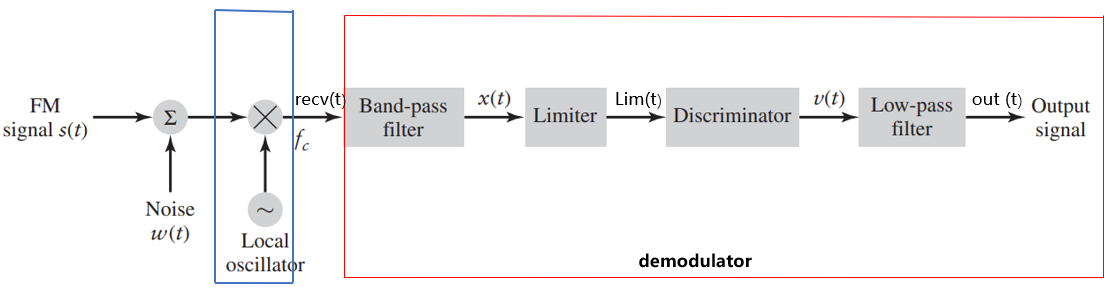

$x\_t = fm\_t + n\_t$, where $n\_t$ is passing BPF w_t

$limited\_t = cos(2*\pi*fc*t+\theta(t))$, where $\theta$ is shown below:

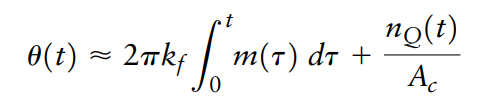

$envelope2 = 2*\pi*fc + 2*\pi*kf*m\_t + 2*\pi*nd\_t$

$v\_t = kf*m\_t + nd\_t$

$output\_t = kf*m\_t$

### Power functions

In [31]:
import numpy as np
from numpy.fft import fft, fftfreq
import scipy.signal as signal

def wrong_PSD(any_t,Fs,periodic=0):
    numfft = 2048
    any_fbin = (fftfreq(numfft, d=1 / Fs))
    any_f = np.abs((fft(any_t,numfft)))
    if periodic==0:
        any_f = any_f/Fs
    else:
        any_f = any_f/numfft

    psd = any_f**2/len(any_f)
    return any_fbin,psd


def PSD(any_t,Fs):
    # nperseg should be smaller than number of any_t
    any_fbin, psd = signal.welch(any_t, fs=Fs, nperseg=2048, noverlap = int(2048*2/4),return_onesided=False)
    return any_fbin,psd


def average_power(any_t,Fs):
    # method 1, it's wrong if any_t is energy signal
    # f,Y = PSD(any_t,Fs)
    # step = (max(f)-min(f))/len(f)
    # result = np.sum(Y)*step

    # method 2, it's always true
    result = np.mean(np.square(any_t))
    return result

### plt function

In [32]:
import numpy as np
import matplotlib.pyplot as plt
def draw(t, signal_t, f, signal_f, signal_name,tmin=-2.5,tmax=2.5,fmin=-150,fmax=150):
    plt.figure(figsize=(16, 8))
    plt.subplot(2, 1, 1)
    plt.plot(t, signal_t)
    plt.title(signal_name+' time domain')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    # plt.xlim(tmin,tmax)  
    plt.grid()

    plt.subplot(2, 1, 2)
    plt.plot(fftshift(f), np.abs(fftshift(signal_f)))
    plt.title(signal_name+' freq domain')
    plt.xlabel('frequency(Hz)')
    plt.ylabel('magnitude')
    # plt.xlim(fmin,fmax)  
    plt.subplots_adjust(left=0.125,
                    bottom=-0.51,
                    right=1.3,
                    top=0.88,
                    wspace=0.2,
                    hspace=0.3)
    plt.grid()

### noise function

In [33]:
import numpy as np
from scipy.signal import savgol_filter

def moving_average(signal_t):
    # Define the window size for the moving average
    window_size = 5  # Adjust this value as needed
    # Apply the moving average to the signal
    filtered_signal = np.convolve(signal_t, np.ones(window_size) / window_size, mode='same')
    return filtered_signal

def sg_filter(signal_t):
    # Define the window size and polynomial order for the Savitzky-Golay filter
    window_size = 21  # Adjust this value as needed (should be an odd number)
    poly_order = 3  # Adjust this value as needed (usually 2 or 3)
    # Apply the Savitzky-Golay filter to the signal
    filtered_signal = savgol_filter(signal_t, window_size, poly_order)
    return filtered_signal


## Triple Call

In [34]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.fft import fft, fftfreq,fftshift,ifft
from PIL import Image
import numpy as np
import os

# Load the image
image = Image.open("figure/large.jpg")
image_height = image.size[1]
image_width = image.size[0]
rgb_image = image.convert("RGB")
image_array = np.array(rgb_image)

red_channel = image_array[:, :, 0].flatten()
green_channel = image_array[:, :, 1].flatten()
blue_channel = image_array[:, :, 2].flatten()

# print("Original Image Shape:", image_array.shape)
# print("Red Channel Length:", len(red_channel))
# print("Green Channel Length:", len(green_channel))
# print("Blue Channel Length:", len(blue_channel))

renorm_t = np.zeros((3, len(red_channel)))
renorm_t_base = np.zeros((3, len(red_channel)))
moving_t = np.zeros((3, len(red_channel)))
sg_t = np.zeros((3, len(red_channel)))
for i in range(3):
    if (i==0):
        origin_t = red_channel
    if (i==2):
        origin_t = blue_channel
    if (i==1):
        origin_t = green_channel
        
    Fs = 100000
    # Calculate the time axis for the waveform plot
    duration = len(origin_t) / Fs
    t = np.linspace(0, duration, len(origin_t))
    m_t = origin_t / np.max(np.abs(origin_t))   # normalize signal to m_t

    # modulation
    ### notice that $Fc$ should be larger than $kf*Am$
    Fc = 25000       # Carrier frequency (Hz)
    kf = 5000    # Frequency sensitivity (Hz/Volt), 
    Ac = 100       # carrier amplitude
    fm_t = generate_fm_signal(t, Fs, m_t, kf, Fc, Ac)

    # calculate bandwidth
    m_fbin = fftfreq(len(m_t), d=1 / (Fs))
    m_f = fft(m_t)/Fs   #非周期函数归一化要乘以1/fs
    fm_fbin = fftfreq(len(fm_t), d=1 / (Fs))
    fm_f = fft(fm_t)/Fs   #FM 信号虽然是cos，但是仍然是非周期函数
    fm_bw = calculate_bandwidth(fm_fbin,abs(fm_f),Fc,0.99999)
    m_bw = calculate_bandwidth(m_fbin,abs(m_f), 0, 0.99999)    
    # print(fm_bw)
    # print(m_bw)

    # demodulation without noise
    recv_t2 = fm_t
    x_t2, limited_t2, v_t2, output_t2 = demodulation(t, recv_t2, Fs, fm_bw, m_bw, Fc, sampe_center=0)
    renorm_t_base[i,:] = np.max(np.abs(origin_t))*output_t2

    # demodulation with noise
    noise_size = 10
    w_t = noise_size*np.random.randn(t.size)
    recv_t = w_t + fm_t
    x_t, limited_t, v_t, output_t= demodulation(t, recv_t, Fs, fm_bw, m_bw, Fc, sampe_center=0)
    renorm_t[i,:] = np.max(np.abs(origin_t))*output_t

    moving_t[i,:] = moving_average(renorm_t[i,:])
    sg_t[i,:] = sg_filter(renorm_t[i,:])

folder_path = 'result/'
if not os.path.exists(folder_path):
    # 如果文件夹不存在则创建
    os.makedirs(folder_path)


red_channel2 = red_channel.reshape((image_height, image_width))
green_channel2 = green_channel.reshape((image_height, image_width))
blue_channel2 = blue_channel.reshape((image_height, image_width))
image_array = np.dstack((red_channel2, green_channel2, blue_channel2))
image = Image.fromarray(np.uint8(image_array))
file_name = 'origin.png'
save_path = folder_path + file_name
image.save(save_path)
image.show()


red_channel2 = (renorm_t_base[0]/kf).reshape((image_height, image_width))
green_channel2 = (renorm_t_base[1]/kf).reshape((image_height, image_width))
blue_channel2 = (renorm_t_base[2]/kf).reshape((image_height, image_width))
image_array = np.dstack((red_channel2, green_channel2, blue_channel2))
image = Image.fromarray(np.uint8(image_array))
file_name = 'demodulation without noise.png'
save_path = folder_path + file_name
image.save(save_path)
image.show()

red_channel2 = (renorm_t[0]/kf).reshape((image_height, image_width))
green_channel2 = (renorm_t[1]/kf).reshape((image_height, image_width))
blue_channel2 = (renorm_t[2]/kf).reshape((image_height, image_width))
image_array = np.dstack((red_channel2, green_channel2, blue_channel2))
image = Image.fromarray(np.uint8(image_array))
file_name = 'demodulation with noise.png'
save_path = folder_path + file_name
image.save(save_path)
image.show()

red_channel2 = (moving_t[0]/kf).reshape((image_height, image_width))
green_channel2 = (moving_t[1]/kf).reshape((image_height, image_width))
blue_channel2 = (moving_t[2]/kf).reshape((image_height, image_width))
image_array = np.dstack((red_channel2, green_channel2, blue_channel2))
image = Image.fromarray(np.uint8(image_array))
file_name = 'moving average method.png'
save_path = folder_path + file_name
image.save(save_path)
image.show()

red_channel2 = (sg_t[0]/kf).reshape((image_height, image_width))
green_channel2 = (sg_t[1]/kf).reshape((image_height, image_width))
blue_channel2 = (sg_t[2]/kf).reshape((image_height, image_width))
image_array = np.dstack((red_channel2, green_channel2, blue_channel2))
image = Image.fromarray(np.uint8(image_array))
file_name = 'sg method.png'
save_path = folder_path + file_name
image.save(save_path)
image.show()
 


## single channel test

In [35]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.fft import fft, fftfreq,fftshift,ifft
from PIL import Image
import numpy as np

# Load the image
image = Image.open("figure/2.png")
image_height = image.size[1]
image_width = image.size[0]
rgb_image = image.convert("RGB")
image_array = np.array(rgb_image)

red_channel = image_array[:, :, 0].flatten()
green_channel = image_array[:, :, 1].flatten()
blue_channel = image_array[:, :, 2].flatten()

print("Original Image Shape:", image_array.shape)
print("Red Channel Length:", len(red_channel))
print("Green Channel Length:", len(green_channel))
print("Blue Channel Length:", len(blue_channel))


### reconstruct
# red_channel = red_channel.reshape((image_height, image_width))
# green_channel = green_channel.reshape((image_height, image_width))
# blue_channel = blue_channel.reshape((image_height, image_width))

# # Combine the channels into an RGB image
# image_array = np.dstack((red_channel, green_channel, blue_channel))

# # Create an image from the numpy array
# image = Image.fromarray(np.uint8(image_array)).show()


origin_t = blue_channel
Fs = 100000
# Calculate the time axis for the waveform plot
duration = len(origin_t) / Fs
t = np.linspace(0., duration, len(origin_t))

m_t = origin_t / np.max(np.abs(origin_t))   # normalize signal to m_t

# modulation
### notice that $Fc$ should be larger than $kf*Am$
Fc = 25000       # Carrier frequency (Hz)
kf = 5000    # Frequency sensitivity (Hz/Volt), 
Ac = 100       # carrier amplitude
fm_t = generate_fm_signal(t, Fs, m_t, kf, Fc, Ac)


Original Image Shape: (100, 100, 3)
Red Channel Length: 10000
Green Channel Length: 10000
Blue Channel Length: 10000


### calculate BW of message signal and FM signal

49160.0
49940.0


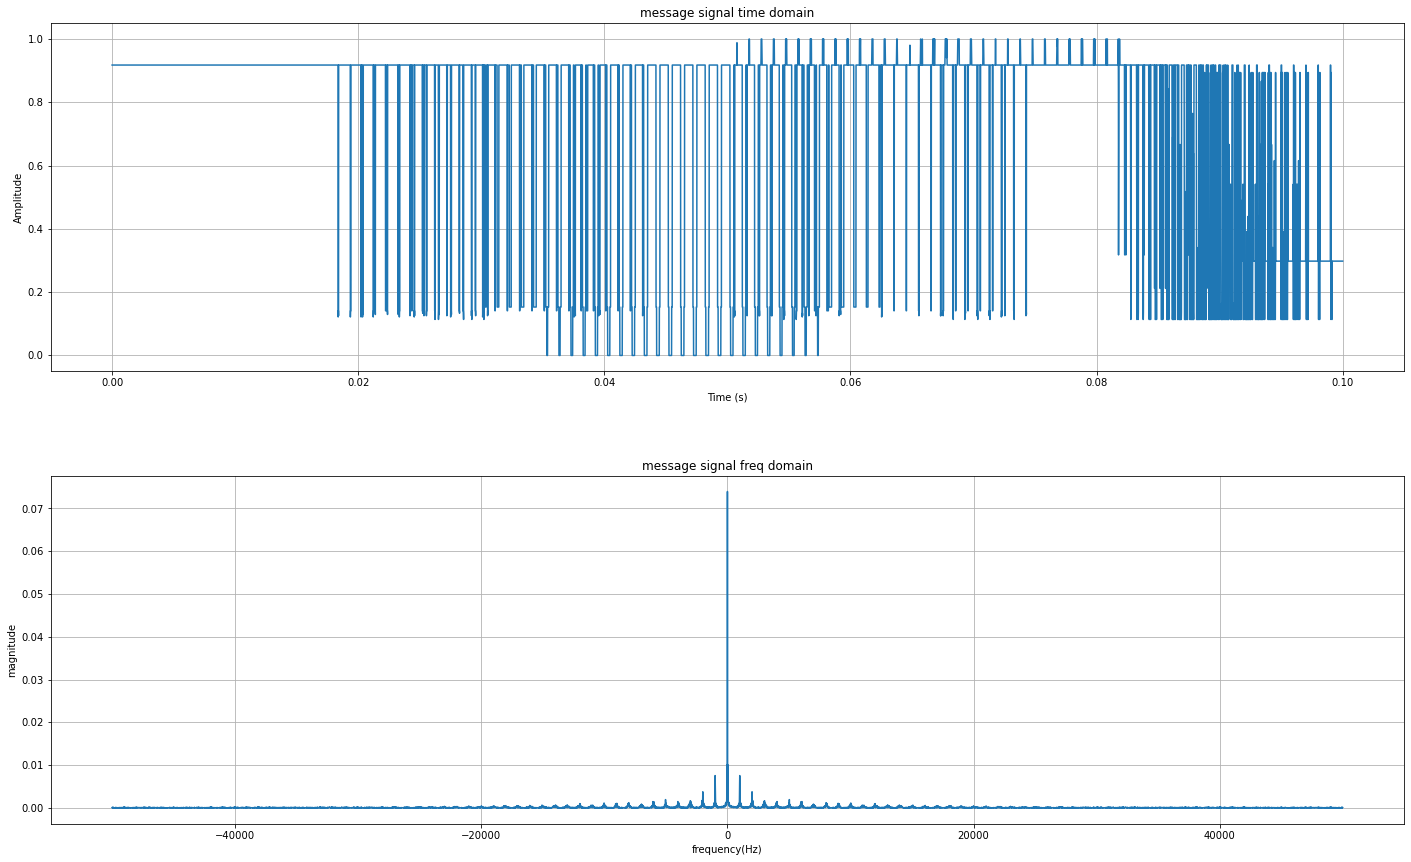

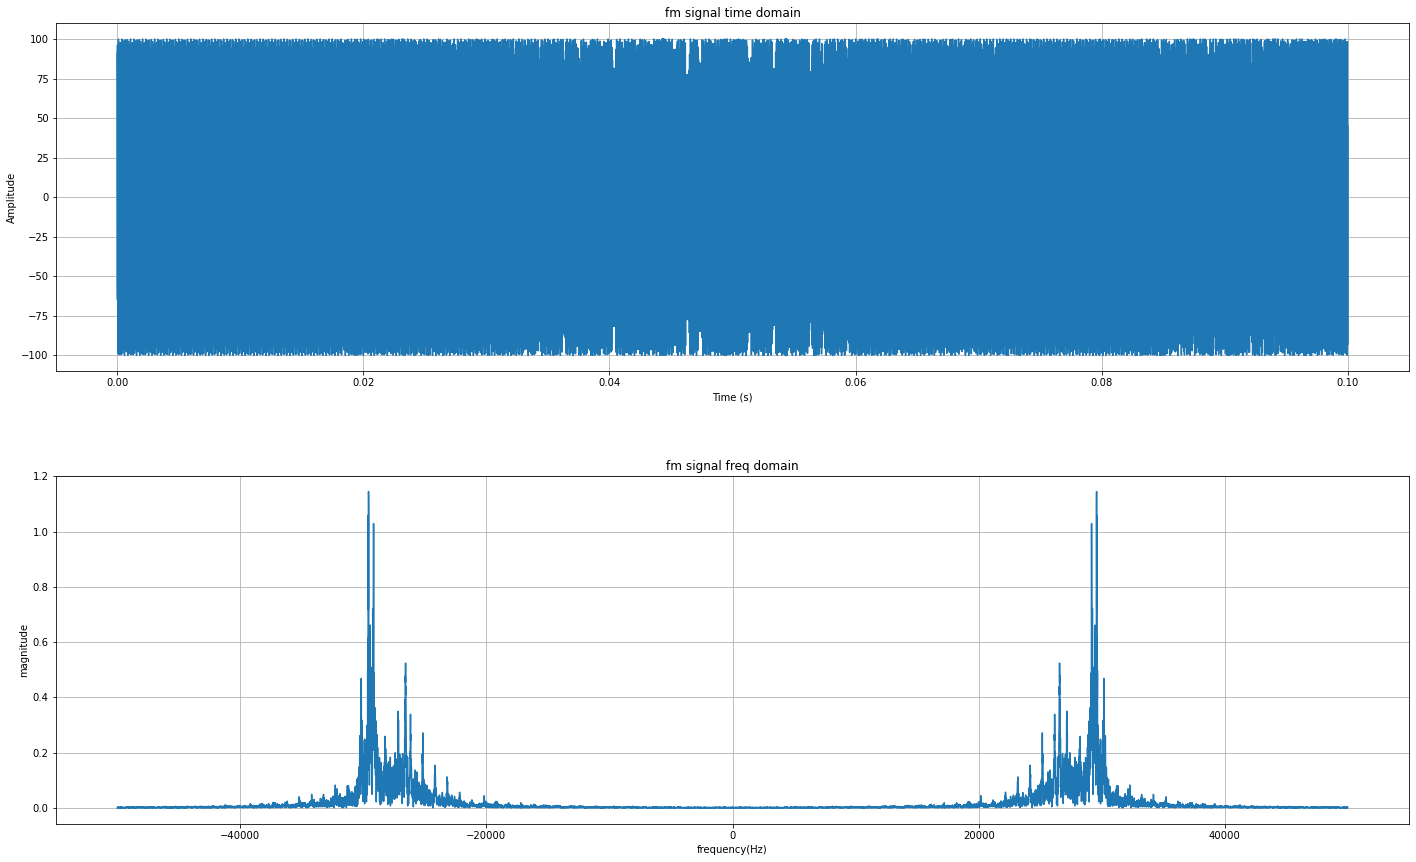

In [36]:
m_fbin = fftfreq(len(m_t), d=1 / (Fs))
m_f = fft(m_t)/Fs   #非周期函数归一化要乘以1/fs
fm_fbin = fftfreq(len(fm_t), d=1 / (Fs))
fm_f = fft(fm_t)/Fs   #FM 信号虽然是cos，但是仍然是非周期函数
fm_bw = calculate_bandwidth(fm_fbin,abs(fm_f),Fc,0.99999)
m_bw = calculate_bandwidth(m_fbin,abs(m_f), 0, 0.99999)    
# fm_bw = 62.5  ### 哈哈，我是替身
# m_bw = 5.5    ### 哈哈，我是替身
print(fm_bw)
print(m_bw)

draw(t,m_t,m_fbin,m_f,"message signal")
draw(t,fm_t,fm_fbin,fm_f,"fm signal")

### demodulation without noise

In [37]:
# add noise
recv_t2 = fm_t

# demodulation
x_t2, limited_t2, v_t2, output_t2 = demodulation(t, recv_t2, Fs, fm_bw, m_bw, Fc, sampe_center=0)


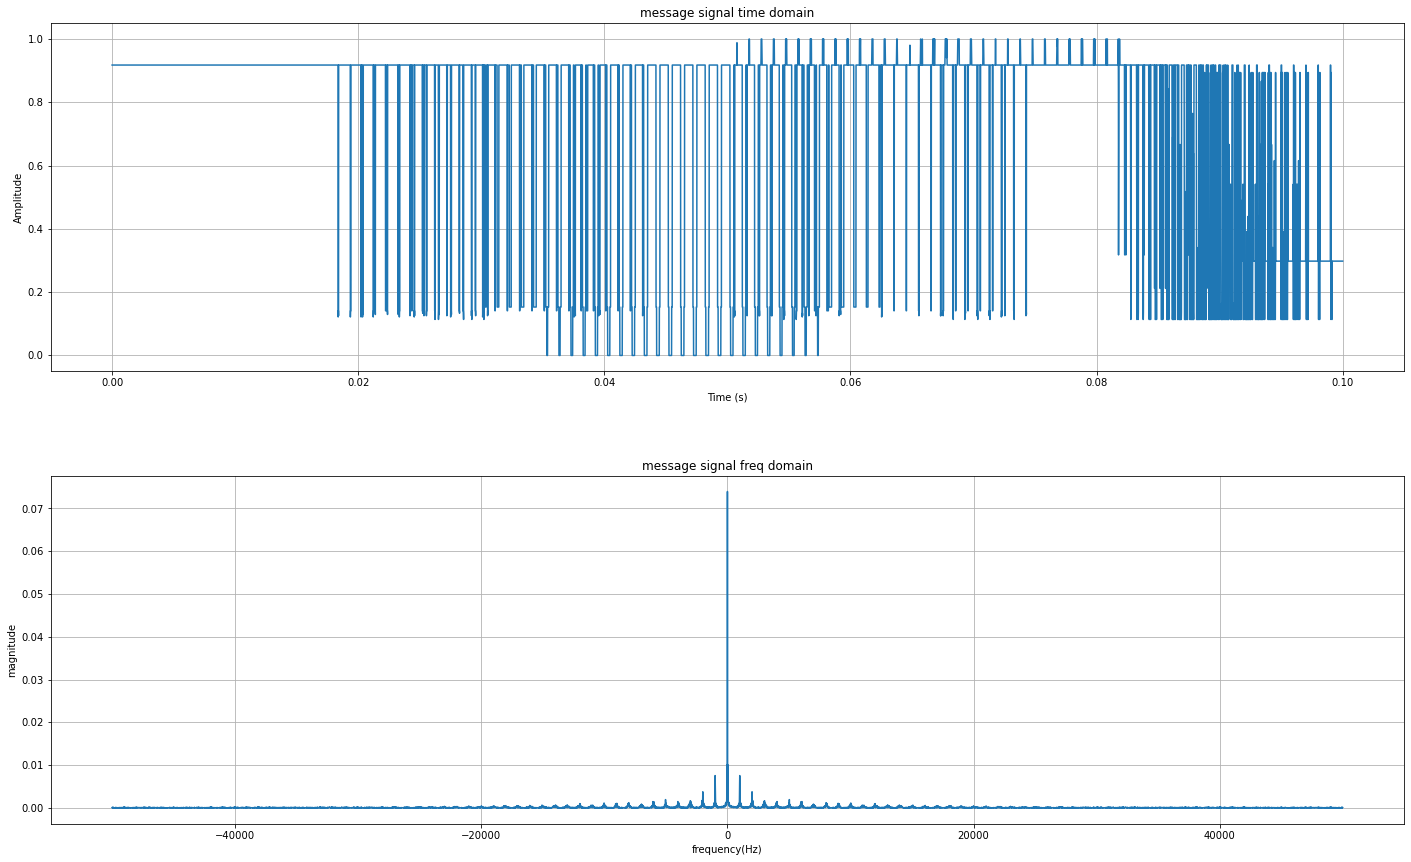

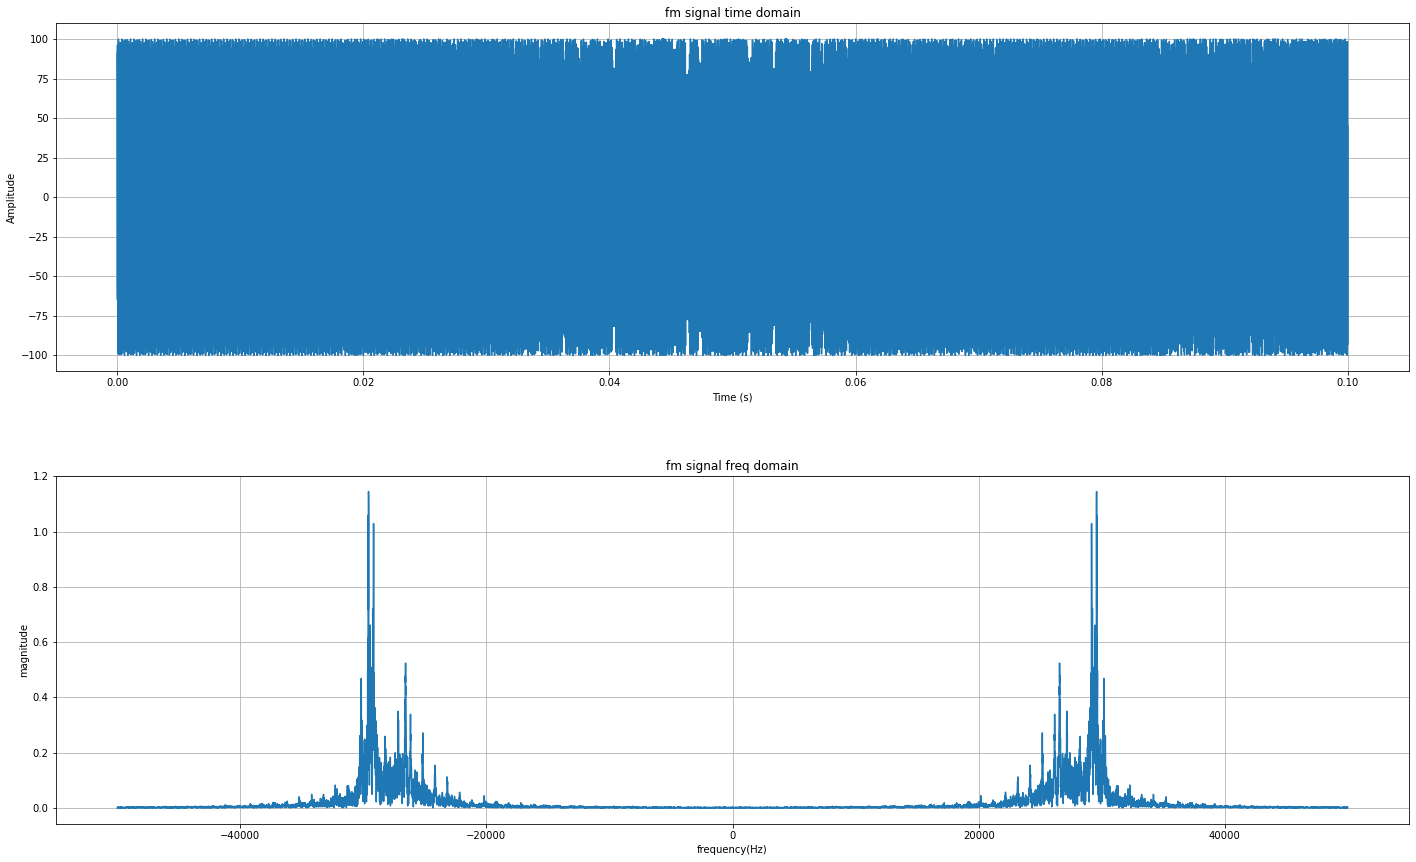

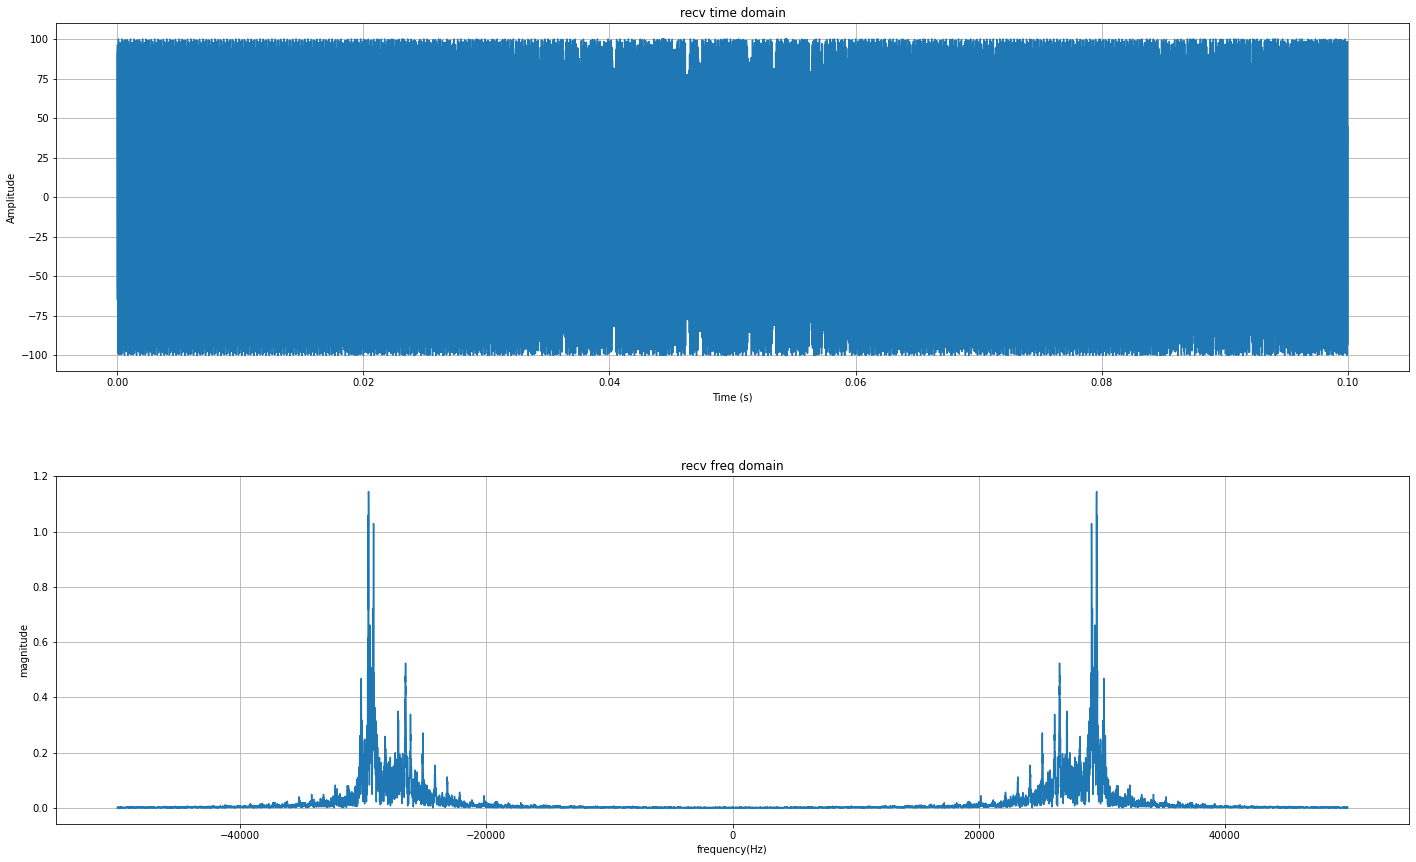

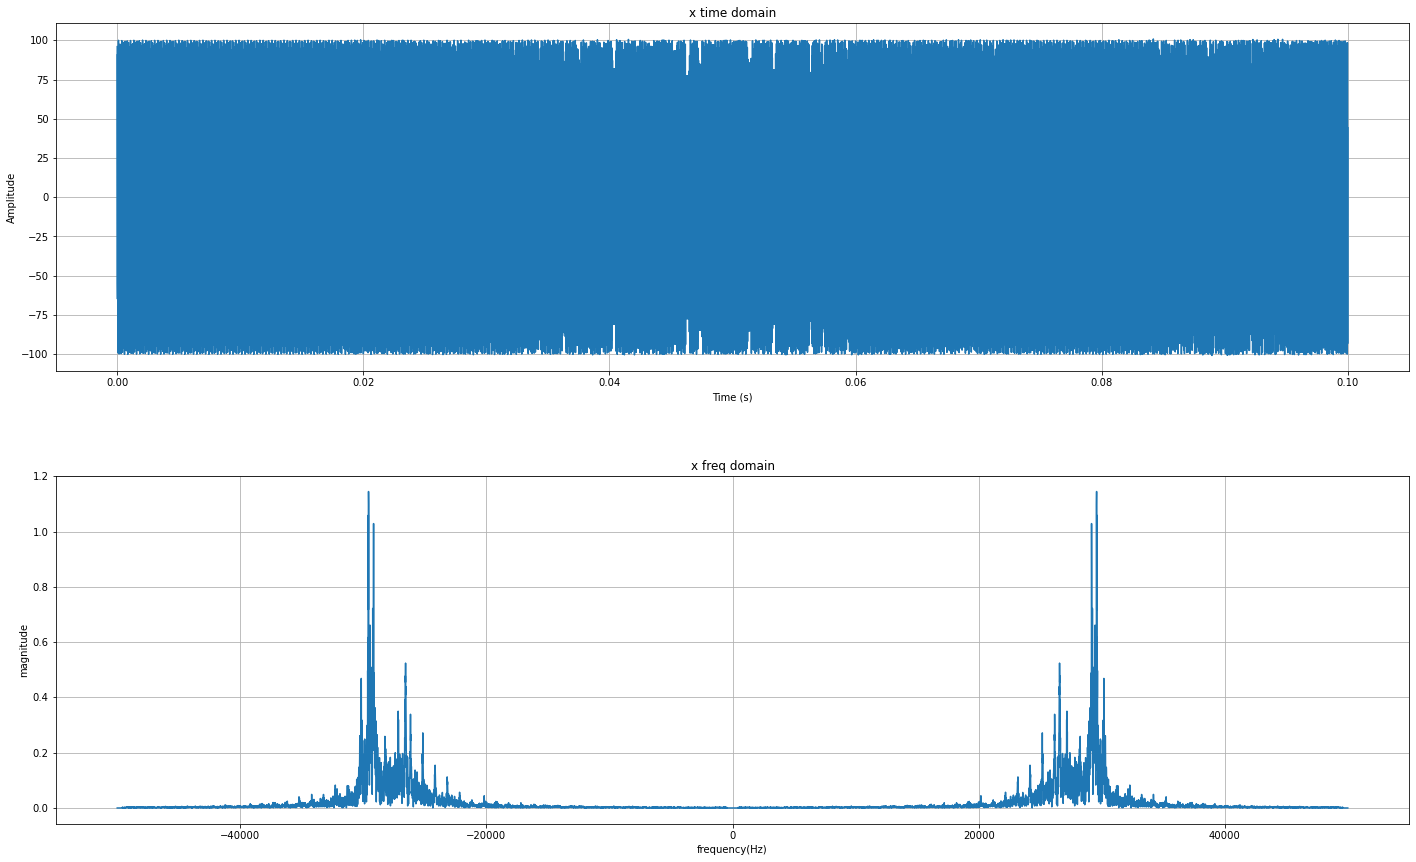

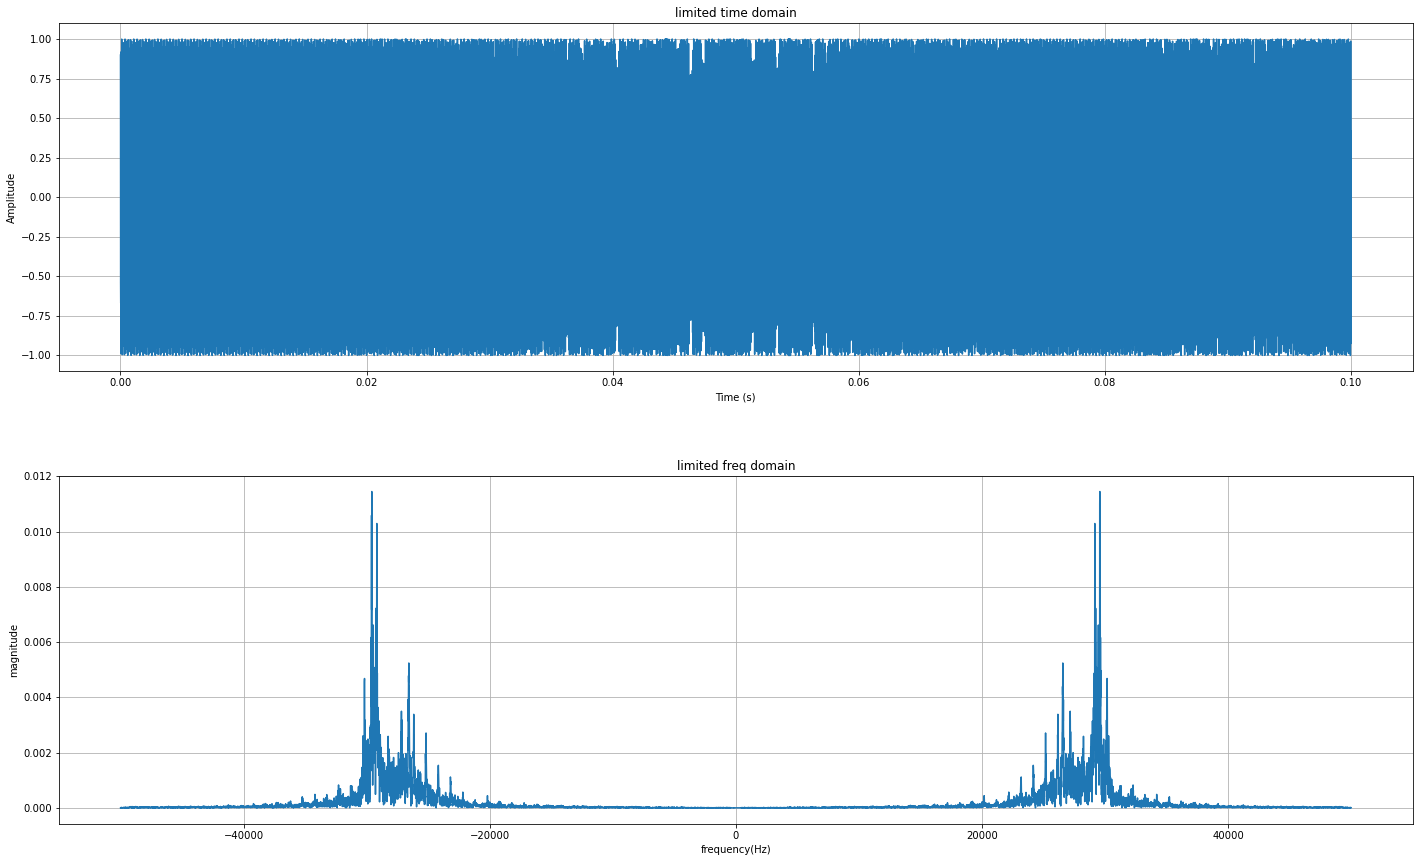

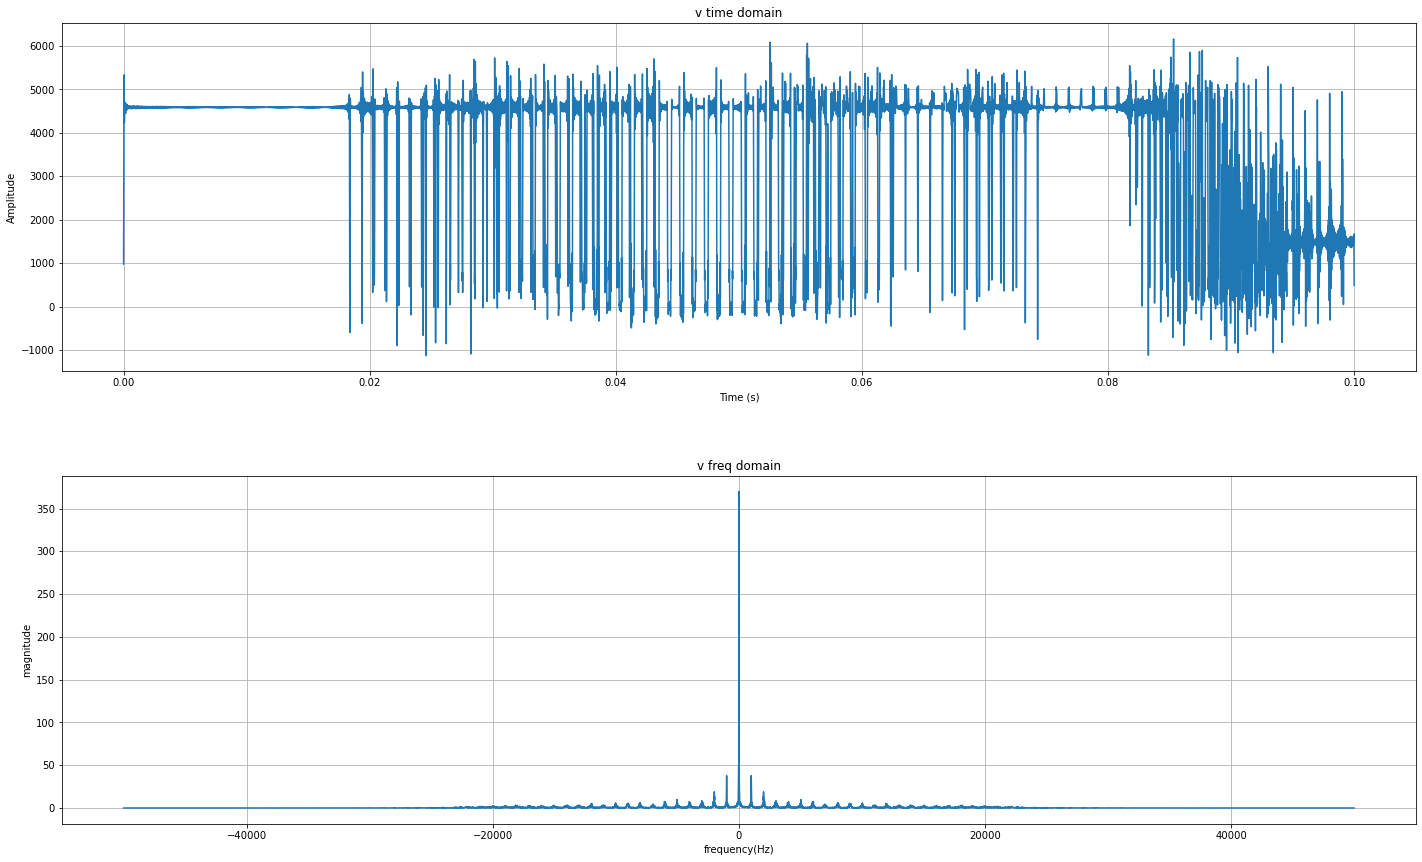

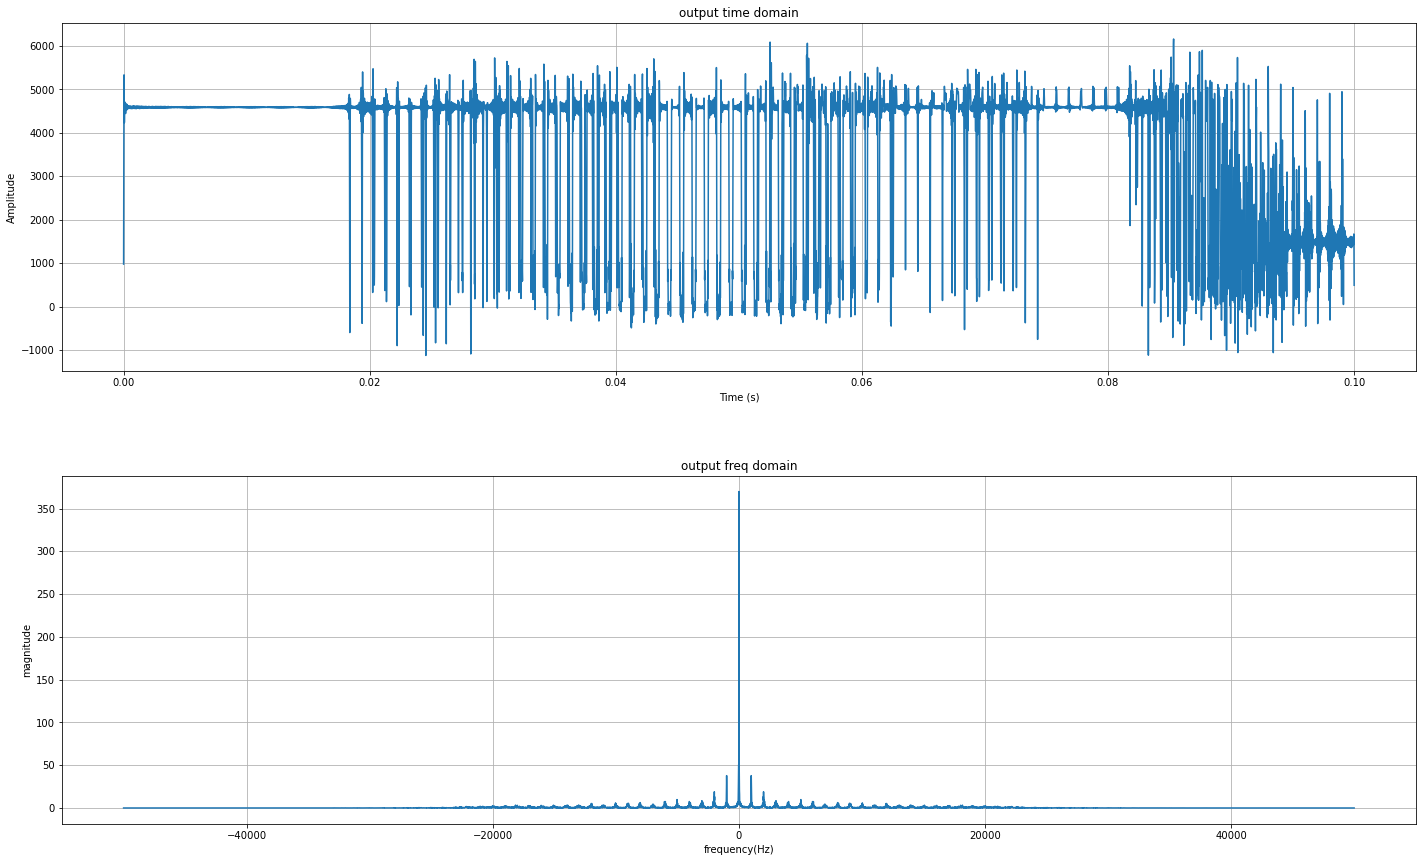

In [38]:
# get freq domain
recv_f = fft(recv_t2)/Fs  
x_f = fft(x_t2)/Fs
limited_f = fft(limited_t2)/Fs
v_f = fft(v_t2)/Fs
output_f = fft(output_t2)/Fs
draw(t,m_t,m_fbin,m_f,"message signal")
draw(t,fm_t,fm_fbin,fm_f,"fm signal")
draw(t,recv_t2,fm_fbin,recv_f,'recv')
draw(t,x_t2,fm_fbin,x_f,"x")
draw(t,limited_t2,fm_fbin,limited_f,"limited")
draw(t,v_t2,fm_fbin,v_f,"v")
draw(t,output_t2,fm_fbin,output_f,"output")

### Noisy signal demodulation

In [39]:
import numpy as np
from numpy.fft import fft, fftshift

# add noise
noise_size = 100
w_t = noise_size*np.random.randn(t.size)
recv_t = w_t + fm_t

# demodulation
x_t, limited_t, v_t, output_t = demodulation(t, recv_t, Fs, fm_bw, m_bw, Fc, sampe_center=0)

### plot figures

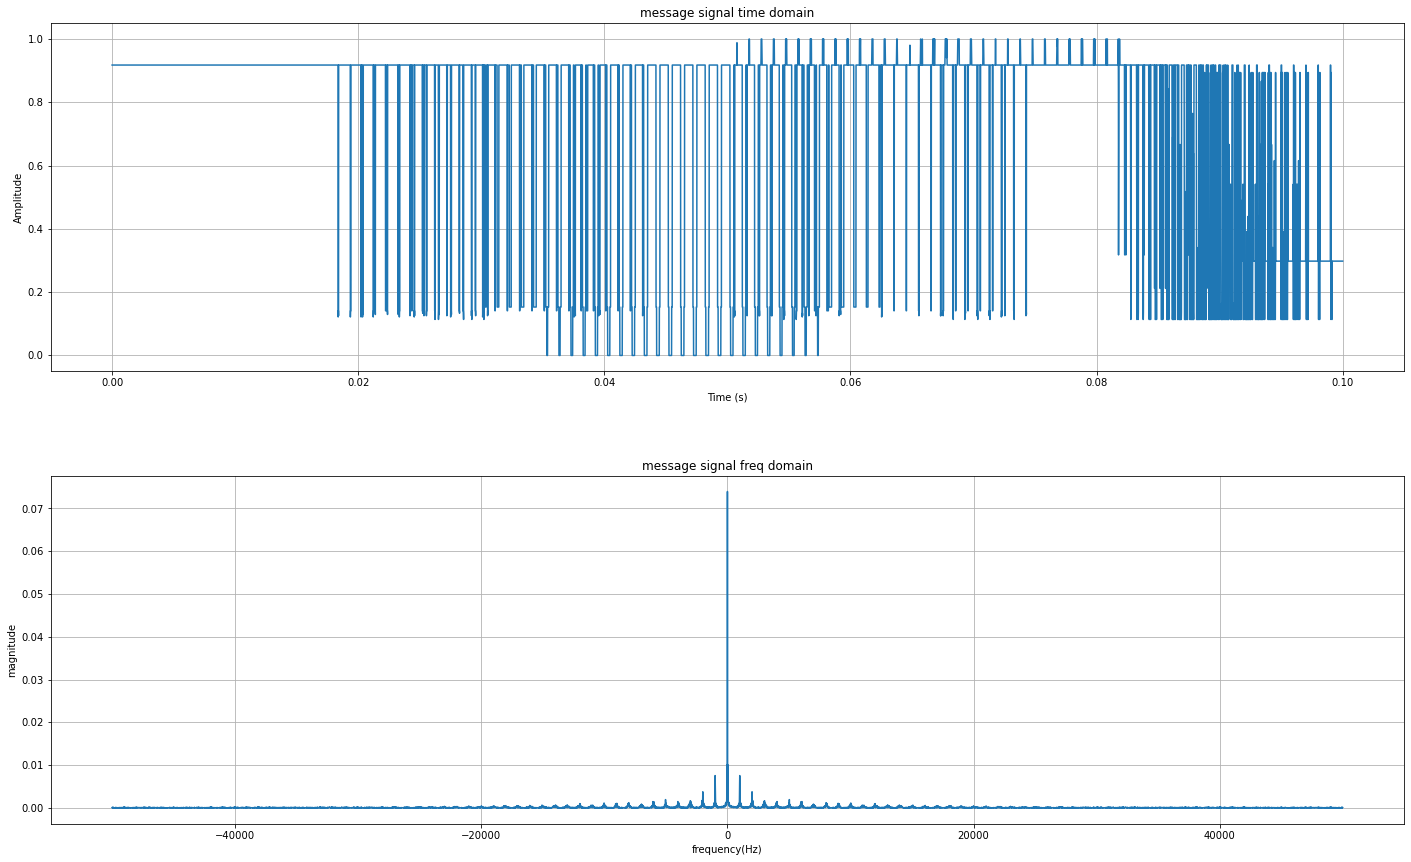

Error in callback <function flush_figures at 0x000001C60ED23550> (for post_execute):


KeyboardInterrupt: 

In [40]:
# get freq domain
recv_f = fft(recv_t)/Fs  
x_f = fft(x_t)/Fs
limited_f = fft(limited_t)/Fs
v_f = fft(v_t)/Fs
output_f = fft(output_t)/Fs
draw(t,m_t,m_fbin,m_f,"message signal")
draw(t,fm_t,fm_fbin,fm_f,"fm signal")
draw(t,recv_t,fm_fbin,recv_f,'recv')
draw(t,x_t,fm_fbin,x_f,"x")
draw(t,limited_t,fm_fbin,limited_f,"limited")
draw(t,v_t,fm_fbin,v_f,"v")
draw(t,output_t,fm_fbin,output_f,"output")